In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [2]:
%load_ext autoreload
%autoreload

import pandas as pd
import pandas_profiling
import numpy as np
import csv
import qgrid

from pa_lib.file import load_csv
from pa_lib.data import as_dtype, desc_col
from pa_lib.types import dtFactor, Record

## Load data

In [2]:
ax = load_csv('axinova_20190606/190016Wochentage.csv', sep=';', quoting=csv.QUOTE_NONE, encoding='cp1252')
ax.DayOfWeek = ax.DayOfWeek.astype('category').cat.reorder_categories(
    'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split(), 
    ordered=True)
ax = (ax
      .assign(logValue=np.log(ax.Value))
      .sort_values(by=['Station', 'DayOfWeek', 'Variable', 'Code'])
      .reset_index(drop=True))
var = Record(**{v:v for v in np.unique(ax.Variable)})
display(desc_col(ax, det=True))

2019-07-02 14:45:29 [INFO] Reading from file C:\Users\kpf\data\axinova_20190606\190016Wochentage.csv
2019-07-02 14:45:29 [INFO] Finished loading CSV in 0.05s (0.05s CPU)


,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,object,0/48322,24,3.7 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/48322,7,48.0 KB,"[Monday,Sunday]"
Variable,object,0/48322,119,3.0 MB,"[g_220,nat_ausland]"
Code,object,0/48322,153,3.5 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter..."
Value,float64,0/48322,37680,377.6 KB,"[0.442782048,881.3661492999998]"
logValue,float64,0/48322,37680,377.6 KB,"[-0.8146776209749247,6.781473146065653]"


In [3]:
pandas_profiling.ProfileReport(ax).to_file(outputfile='ax_profile.html')

In [4]:
qgrid.show_grid(ax)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Check code distributions

In [5]:
ax.DayOfWeek.value_counts()

Friday       7013
Wednesday    7007
Thursday     6980
Monday       6857
Sunday       6853
Tuesday      6820
Saturday     6792
Name: DayOfWeek, dtype: int64

In [6]:
ax.Station.value_counts()

Zürich HB             2405
Bern                  2279
Zürich Oerlikon       2201
Zürich Hardbrücke     2153
Luzern                2139
Olten                 2129
Basel SBB             2122
Zürich Stadelhofen    2107
Zürich Flughafen      2089
Lausanne              2083
Zug                   2064
Winterthur            2055
Genève Cornavin       2038
Fribourg              2026
Aarau                 2018
Biel/Bienne           1994
Lugano                1986
St. Gallen            1927
Genève Aéroport       1892
Zürich Enge           1830
Bellinzona            1798
Neuchatel             1708
Chur                  1678
Brig                  1601
Name: Station, dtype: int64

In [7]:
qgrid.show_grid(ax.Variable.value_counts())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [8]:
qgrid.show_grid(ax.Code.value_counts())

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Distribution of codes within variables

### Overall

In [9]:
qgrid.show_grid(ax.groupby(by=['Variable', 'Code'], observed=True)['Value'].agg('sum').astype('int'))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Split by Station

In [10]:
qgrid.show_grid(ax.pivot_table(values='Value', index=['Variable', 'Code'], columns='Station', aggfunc='sum', margins=True)
                .fillna(0).astype('int'), 
                grid_options={'maxVisibleRows': 30})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Split by Weekday

In [11]:
tmp = ax.pipe(as_dtype, 'object', incl_col='DayOfWeek')
qgrid.show_grid(tmp.pivot_table(values='Value', index=['Variable', 'Code'], columns='DayOfWeek', aggfunc='sum', margins=True)
                .fillna(0).astype('int')
                .loc[:,'Monday Tuesday Wednesday Thursday Friday Saturday Sunday All'.split()],
                grid_options={'maxVisibleRows': 30})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [12]:
del(tmp)

## Pivot tables (sum of "Value")

### Stations vs. Weekdays

In [14]:
qgrid.show_grid(ax.pivot_table(values='Value', index='Station', columns='DayOfWeek', aggfunc='sum', margins=True).astype('int'))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Variables vs. Stations

In [15]:
qgrid.show_grid(ax.pivot_table(values='Value', index='Variable', columns='Station', aggfunc='sum', margins=True).fillna(0).astype('int'))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Variables vs. Weekdays

In [16]:
qgrid.show_grid(ax.pivot_table(values='Value', index='Variable', columns='DayOfWeek', aggfunc='sum', margins=True).fillna(0).astype('int'))

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Tests for Independence

In [28]:
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set(rc={'figure.dpi': 90, 'figure.figsize': [20, 10]})

In [18]:
def plot_tables(variable):
    data = ax.loc[ax.Variable==variable]
    data_by_weekday = data.pivot_table(values='logValue', index='Code', columns='DayOfWeek', aggfunc='sum', fill_value=0)
    data_by_station = data.pivot_table(values='logValue', index='Code', columns='Station', aggfunc='sum', fill_value=0)
    table_by_weekday = sm.stats.Table(data_by_weekday)
    table_by_station = sm.stats.Table(data_by_station)
    print(f'Test by weekday: p={table_by_weekday.test_nominal_association().pvalue:.3f}')
    print(f'Test by station: p={table_by_station.test_nominal_association().pvalue:.3f}')  
    plt.subplot(1, 2, 1)
    sns.heatmap(table_by_weekday.resid_pearson, center=0)
    plt.subplot(1, 2, 2)
    sns.heatmap(table_by_station.resid_pearson, center=0)
    
def table_stats(variable):
    data = ax.loc[ax.Variable==variable]
    data_by_weekday = data.pivot_table(values='logValue', index='Code', columns='DayOfWeek', aggfunc='sum', fill_value=0)
    data_by_station = data.pivot_table(values='logValue', index='Code', columns='Station', aggfunc='sum', fill_value=0)
    table_by_weekday = sm.stats.Table(data_by_weekday)
    table_by_station = sm.stats.Table(data_by_station)
    p_weekday = table_by_weekday.test_nominal_association().pvalue
    p_station = table_by_station.test_nominal_association().pvalue
    return {'var': variable, 'p_weekday': p_weekday, 'p_station': p_station}

In [19]:
all_var_tables = pd.DataFrame.from_records(
    columns='var p_weekday p_station'.split(),
    data=[table_stats(v) for v in var],
    index='var'
)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\contingency_tables.py:334: RuntimeWarning: invalid value encountered in sqrt
  resids = (self.table - fit) / np.sqrt(fit)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [20]:
qgrid.show_grid(all_var_tables)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [21]:
all_var_tables.loc[all_var_tables.p_station <= 0.05]

,p_weekday,p_station
var,,
g_501,0.984399,1.210856e-02
g_503,0.723948,7.448163e-09
g_504,0.974926,0.000000e+00
g_505,0.999509,4.935304e-04
g_507,0.986378,6.116674e-11
g_508,0.729985,5.184742e-14
g_515,0.994666,1.646022e-04
g_516,0.665439,2.051952e-04
g_517,0.777930,2.186237e-10


Test by weekday: p=0.019
Test by station: p=nan


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\contingency_tables.py:334: RuntimeWarning: invalid value encountered in sqrt
  resids = (self.table - fit) / np.sqrt(fit)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


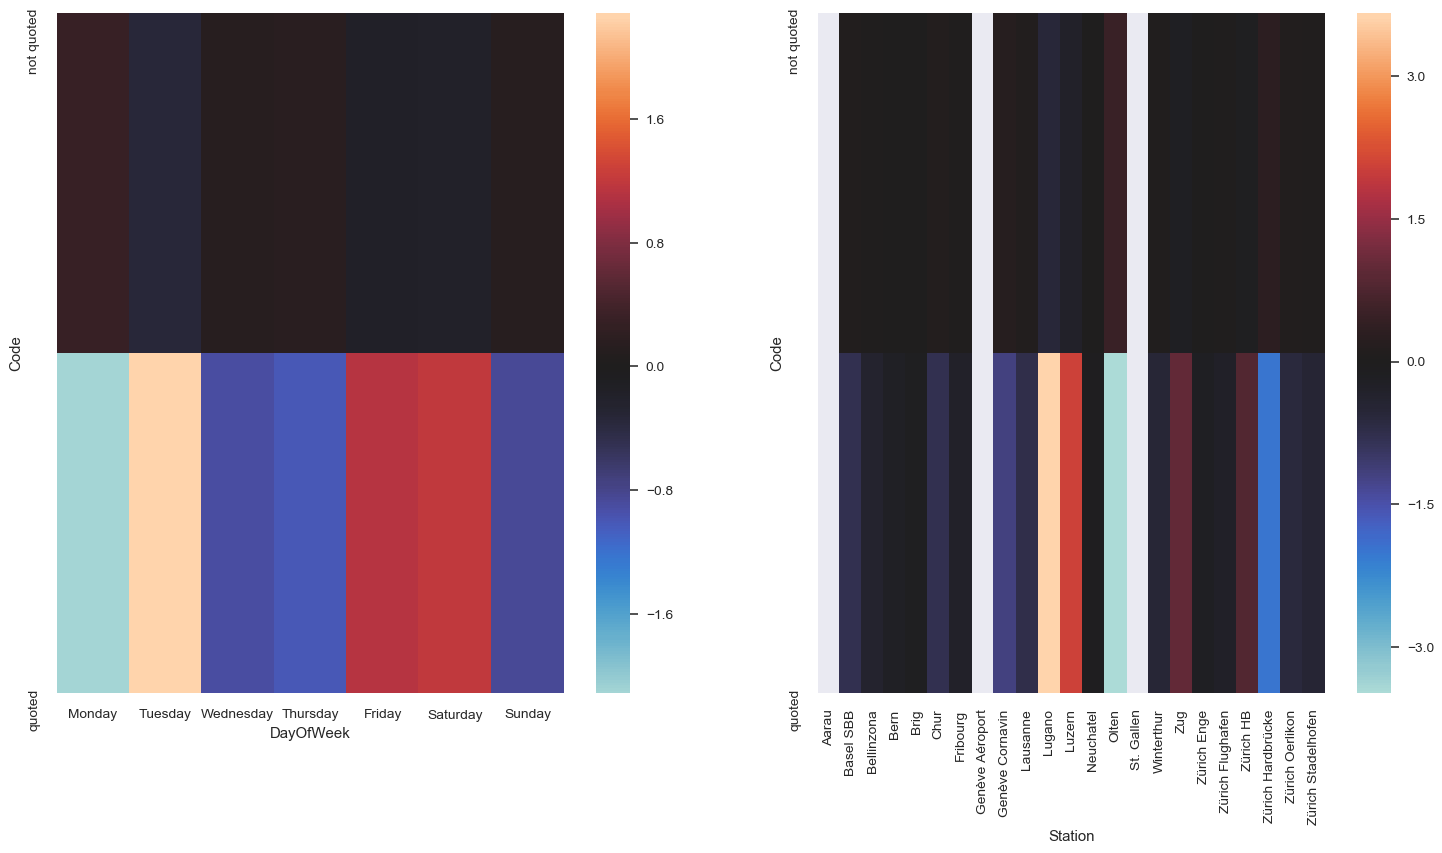

In [30]:
plot_tables(var.g_534)

Test by weekday: p=1.000
Test by station: p=0.000


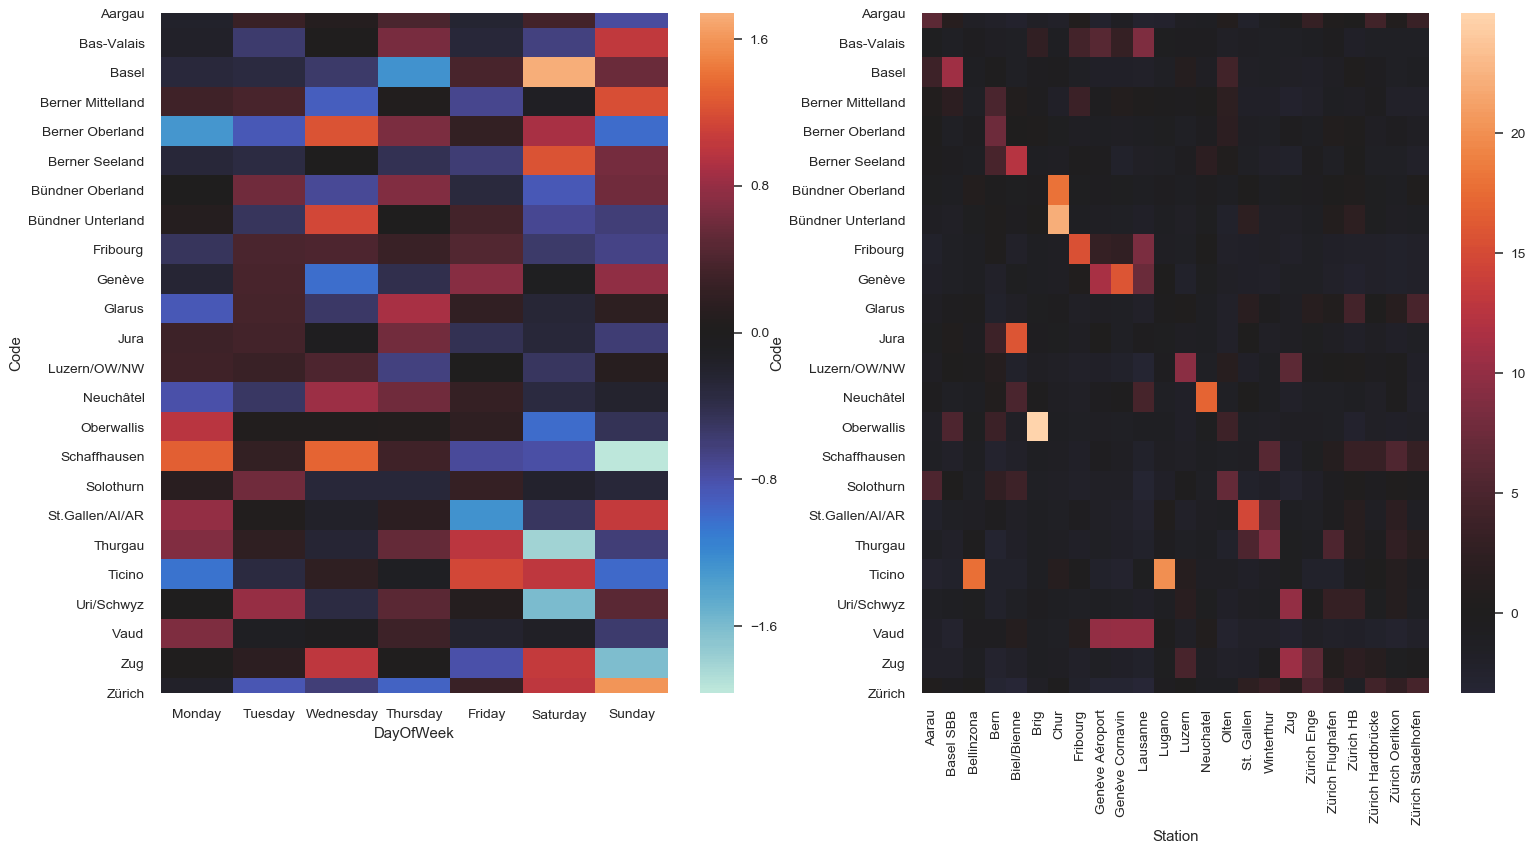

In [32]:
plot_tables('md_gebiet')

Test by weekday: p=0.870
Test by station: p=0.000


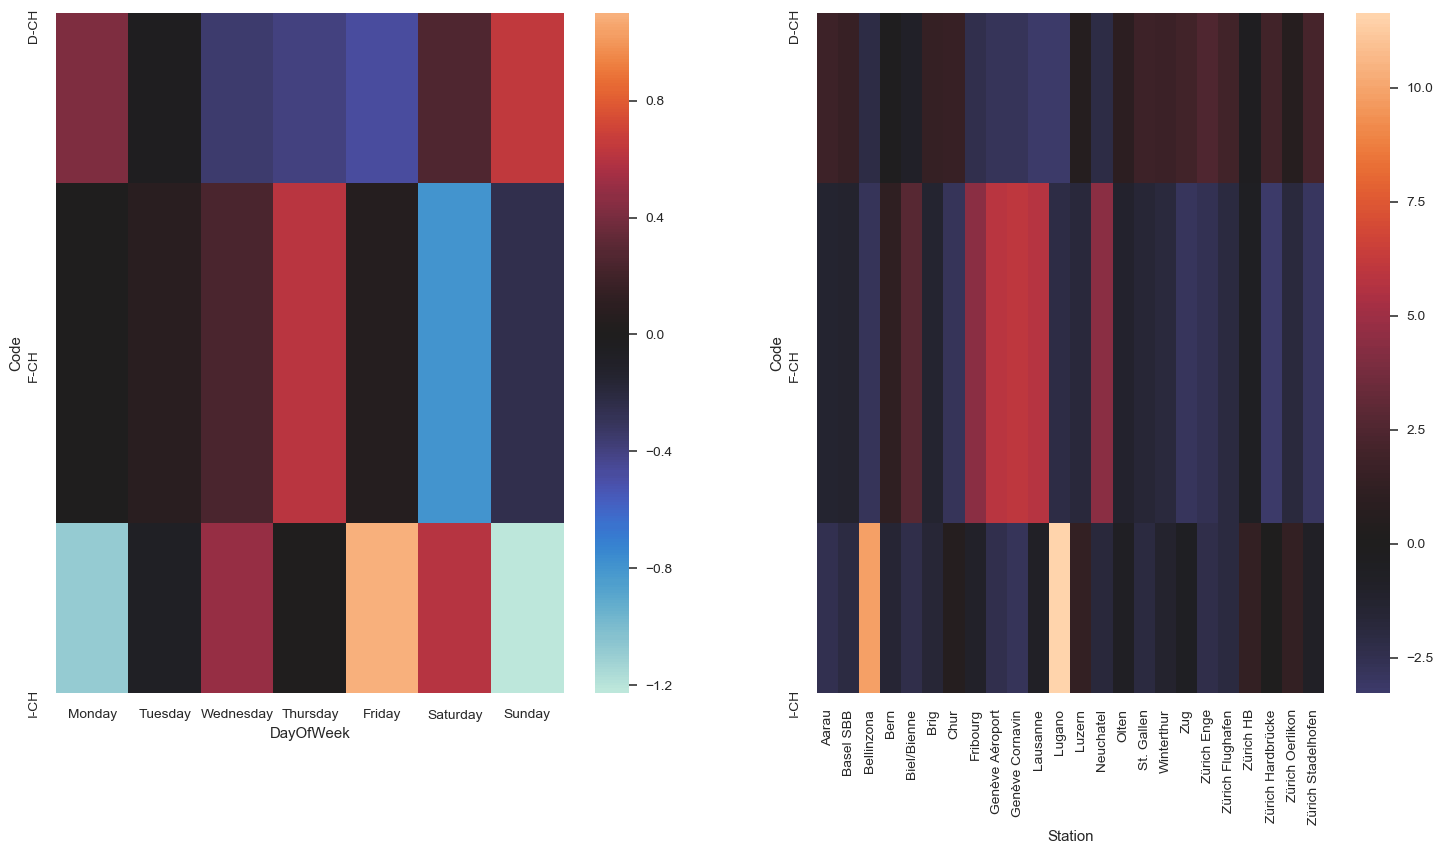

In [33]:
plot_tables('g_sprachregion')

Test by weekday: p=1.000
Test by station: p=0.017


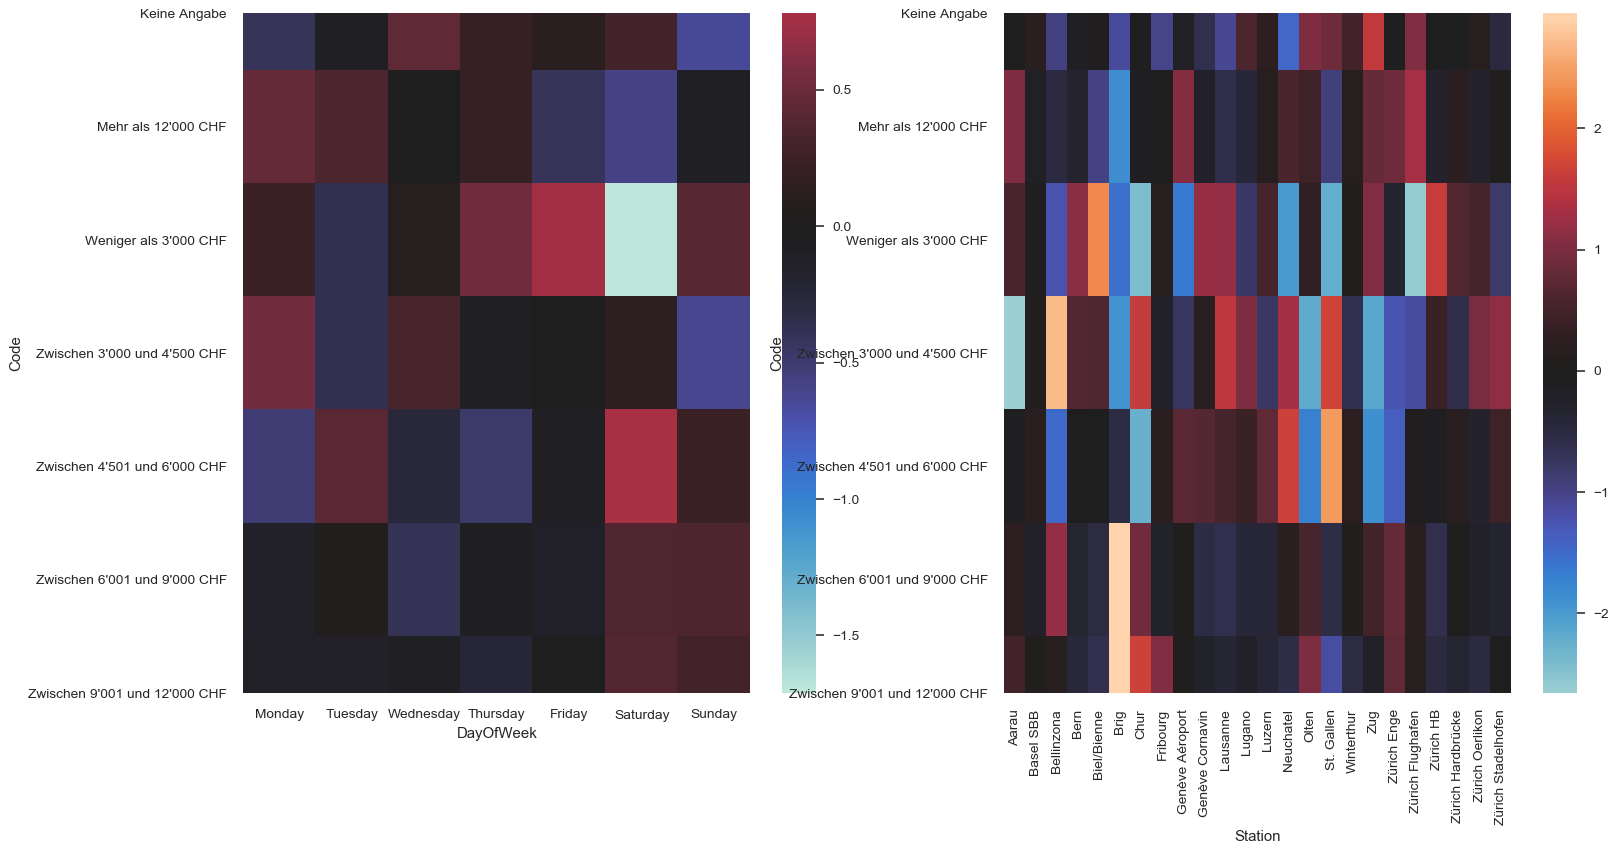

In [34]:
plot_tables('md_ek')

Test by weekday: p=0.474
Test by station: p=0.000


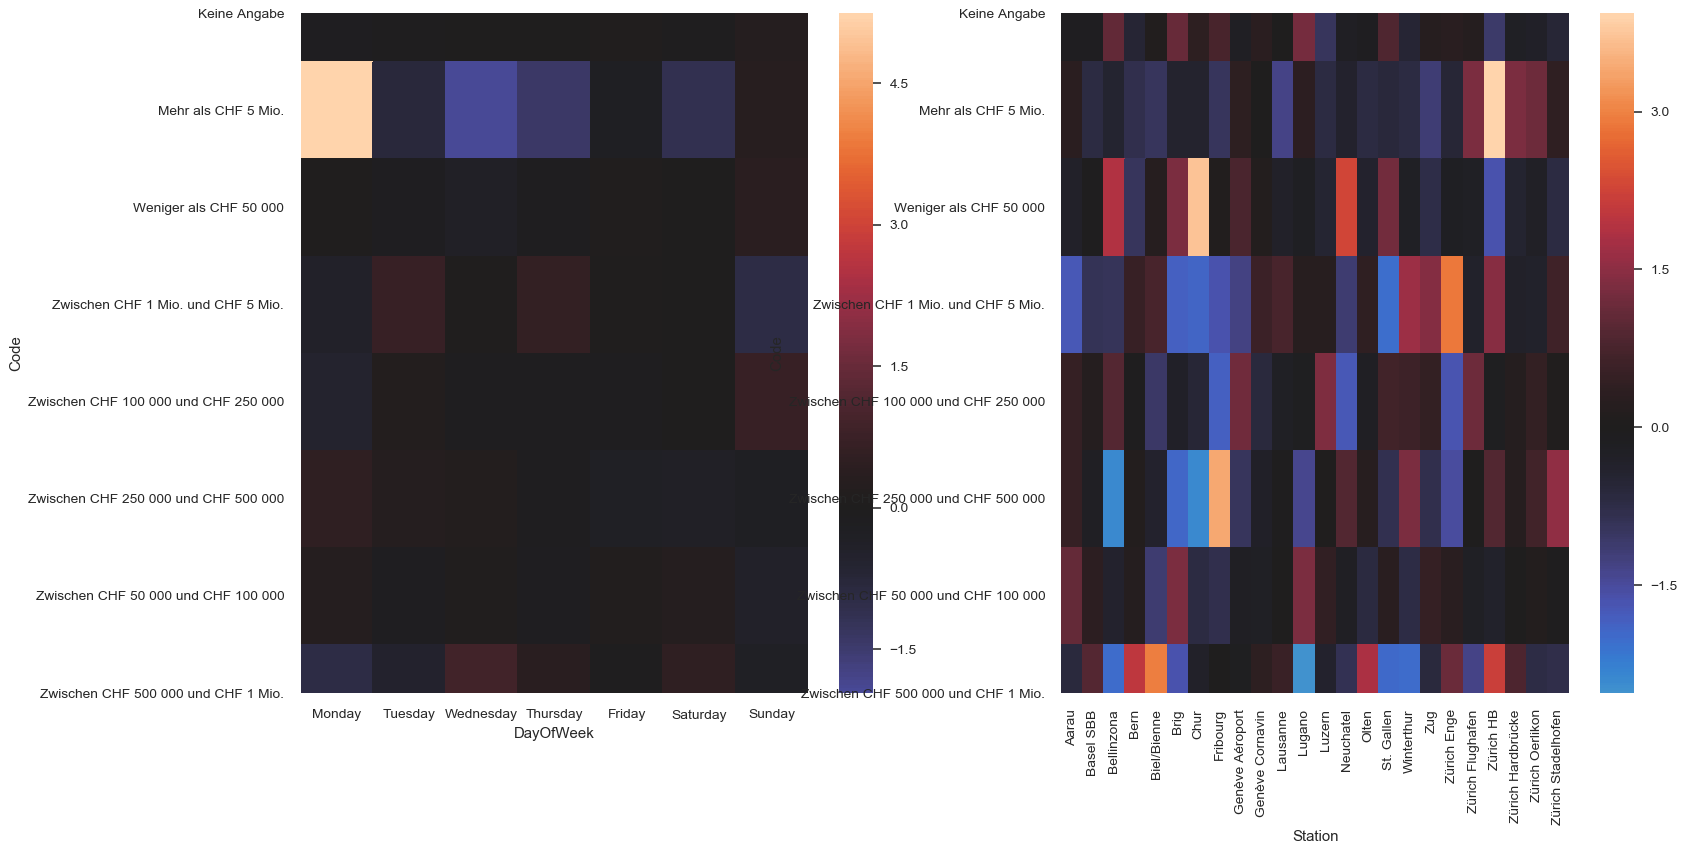

In [35]:
plot_tables('md_hhverm')

Test by weekday: p=1.000
Test by station: p=0.000


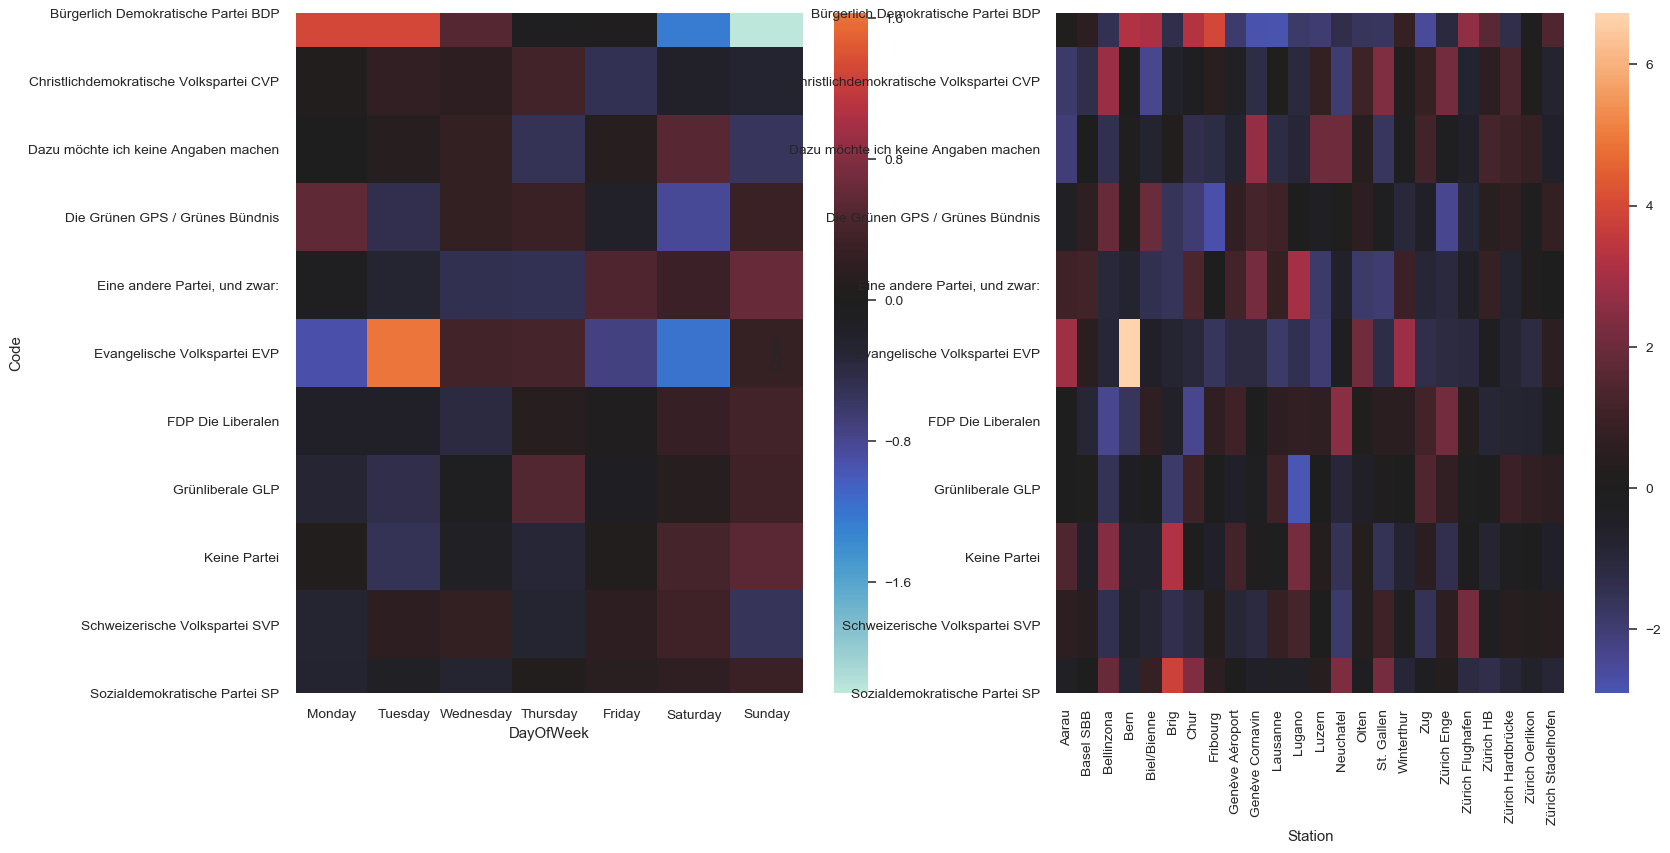

In [36]:
plot_tables('md_880')

Test by weekday: p=1.000
Test by station: p=0.008


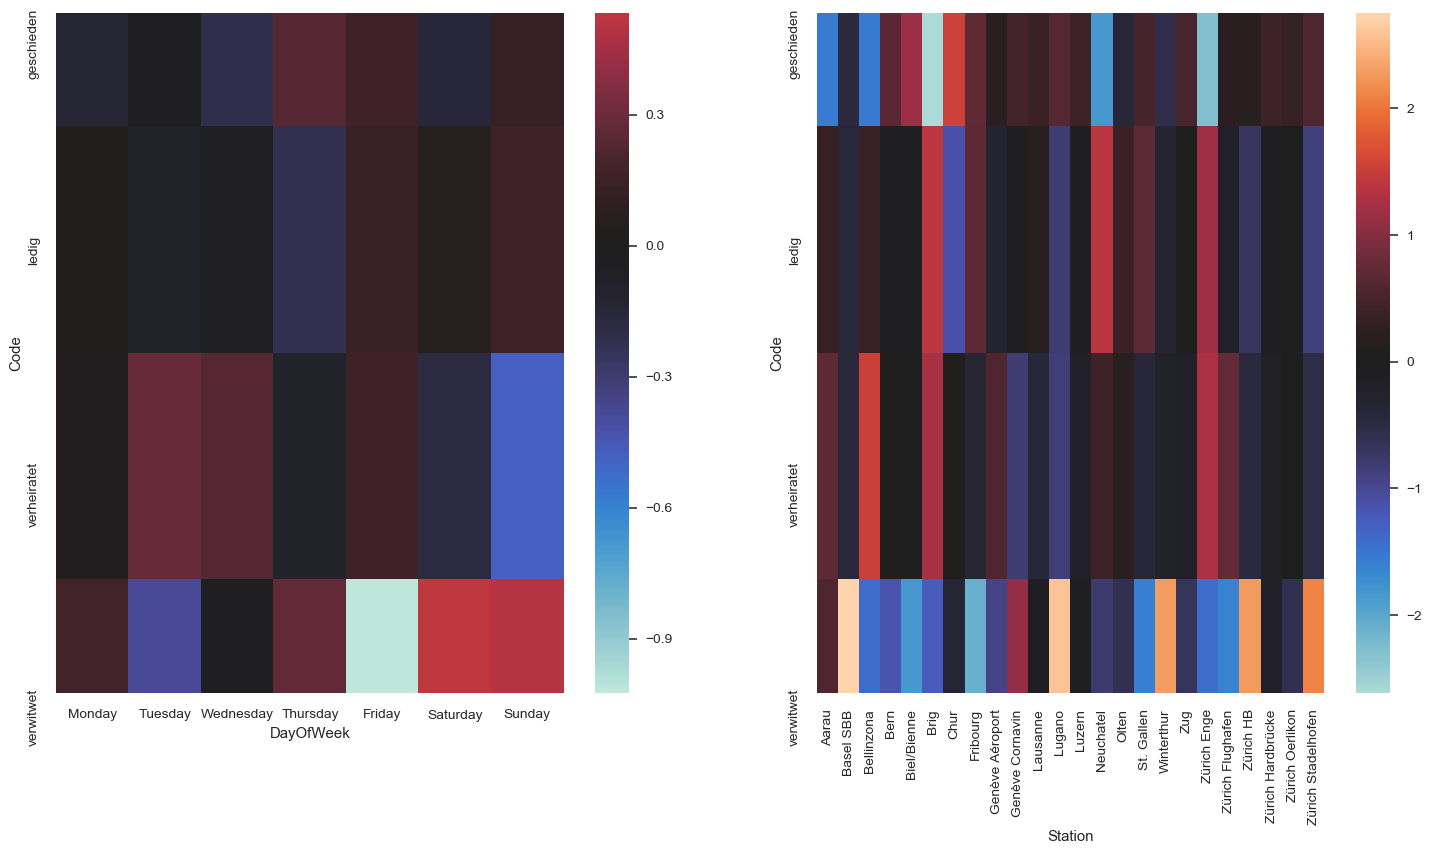

In [37]:
plot_tables(var.md_zivil)

## Models

### ANOVA

In [38]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.graphics.regressionplots as spl

In [39]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def calc_anova(variable, formula='logValue ~ Code + Station + DayOfWeek'):
    data = ax.loc[ax.Variable==variable]
    data = data.assign(label=data.Station.str.cat([data.DayOfWeek.str[:3], data.Code], sep='|'))
    data.set_index('label', inplace=True)
    mod = smf.ols(formula=formula, data=data)
    res = mod.fit()
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())
    #print(res.get_influence().summary_table())
    #spl.influence_plot(res)
    #sns.catplot(x="Station", y='logValue', col='DayOfWeek', kind="box", col_wrap=2, data=ax.loc[ax.Variable==variable])
    
def anova_stats(variable):
    """ANOVA statistics"""
    data = ax.loc[ax.Variable==variable]
    #
    lm_full =         smf.ols(formula='logValue ~ Code + Station + DayOfWeek', data=data).fit()
    lm_code_station = smf.ols(formula='logValue ~ Code * Station', data=data).fit()
    lm_code_weekday = smf.ols(formula='logValue ~ Code * DayOfWeek', data=data).fit()
    lm_station =      smf.ols(formula='logValue ~ Code + Station', data=data).fit()
    lm_weekday =      smf.ols(formula='logValue ~ Code + DayOfWeek', data=data).fit()
    #
    return {'var':variable, 'code+station+weekday':lm_full.rsquared, 'code*station': lm_code_station.rsquared, 'code*weekday': lm_code_weekday.rsquared, 
            'code+station':lm_station.rsquared, 'code+weekday':lm_weekday.rsquared}

In [40]:
all_var_stats = pd.DataFrame.from_records(
    columns='var code+station+weekday code*station code*weekday code+station code+weekday'.split(),
    data=[anova_stats(v) for v in var.keys()],
    index='var'
)

all_var_stats = all_var_stats.assign(**{
    'plus_weekday':      np.subtract(all_var_stats['code+station+weekday'], all_var_stats['code+station']),
    'plus_code*station': np.subtract(all_var_stats['code*station'], all_var_stats['code+station']),
    'plus_code*weekday': np.subtract(all_var_stats['code*weekday'], all_var_stats['code+station']),
})

In [41]:
qgrid.show_grid(all_var_stats.loc[:,'code+station plus_weekday plus_code*station plus_code*weekday'.split()])

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [43]:
calc_anova(var.md_zivil, formula='logValue ~ Code + Station')

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Code,693.044871,3.0,231.014957,695.899424,1.409275e-188,0.562548,0.561588
Station,352.696725,23.0,15.334640,46.193404,2.245910e-113,0.286286,0.280013
Residual,186.232933,561.0,0.331966,NaN,NaN,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:               logValue   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     106.8
Date:                Tue, 02 Jul 2019   Prob (F-statistic):          4.12e-198
Time:                        15:20:35   Log-Likelihood:                -496.32
No. Observations:                 588   AIC:                             1047.
Df Residuals:                     561   BIC:                             1165.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     